In [1]:
import os
import pandas as pd
import json
import multiSyncPy as msp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.chdir("eSports_Sensors_Dataset-master")

In [3]:
for root, dirs, files in os.walk("eSports_Sensors_Dataset-master/matches", topdown=False):
   for name in files:
      print(os.path.join(root, name))
   for name in dirs:
      print(os.path.join(root, name))

In [4]:
player_info = pd.read_csv('players_info.csv')

In [5]:
# change directory to the matches folder
os.chdir('matches')

In [6]:
import os
import pandas as pd
import json

def load_data(n_matches=22, team_type = 'all'):
    """
    Loads data for a specified number of matches from the current working directory.
    Each match is represented as a dictionary within a larger dictionary of matches, replacing the need for a Match class.

    Parameters:
    n_matches (int): The number of match directories to process. Default is 22.

    Returns:
    dict: A dictionary with match IDs as keys. Each key maps to another dictionary that contains match data, including
    environmental data, meta information, replay data, and player data.

    Raises:
    FileNotFoundError: If any of the expected files ('environment.csv', 'meta_info.json', 'replay.json') are missing
    in the match directory.
    """

    print(f'Loading {n_matches} matches ...')
    players_order = ['player_0', 'player_1', 'player_2', 'player_3', 'player_4']
    matches = {}
    wd = os.getcwd()
    ctr = 0
    print(f'Loading match {ctr}...')
    for m in os.listdir(wd):
        match_data = {
            'env': None,
            'meta_info': None,
            'replay': None,
            'players': {}
        }

        match_data['env'] = pd.read_csv(os.path.join(wd, m, 'environment.csv'))
        with open(os.path.join(wd, m, 'meta_info.json'), 'r') as f:
            match_data['meta_info'] = json.load(f)
        with open(os.path.join(wd, m, 'replay.json'), 'r') as f:
            match_data['replay'] = json.load(f)
        # load pros only
        if team_type == 'pros':
          if match_data['meta_info']['team'] == 'amateurs':
            print(f'skipping match {ctr} : amateurs')
            continue
        if team_type == 'amateurs':
          if match_data['meta_info']['team'] != 'amateurs':
            print(f'skipping match {ctr}: pros')
            continue
        for player_id in players_order:
            player_data = {}
            player_path = os.path.join(wd, m, player_id)
            if os.path.exists(player_path):
                for file in os.listdir(player_path):
                    file_path = os.path.join(player_path, file)
                    if file.endswith('.csv'):
                        attribute_name = file[:-4]  # Remove .csv extension
                        player_data[attribute_name] = pd.read_csv(file_path)
                    elif file.endswith('.json'):
                        attribute_name = file[:-5]  # Remove .json extension
                        with open(file_path, 'r') as f:
                            player_data[attribute_name] = json.load(f)
                match_data['players'][player_id] = player_data

        matches[m] = match_data
        ctr += 1
        if ctr >= n_matches:
            break

    return matches


In [7]:
matches = load_data()

Loading 22 matches ...
Loading match 0...


Creating overviews to handle missing data

In [8]:
#Functions for each physiological signal to check the zero proportions of the data
def check_heartrate_data(heartrate_df):
    
    if ((heartrate_df["heart_rate"] == 0).sum() / heartrate_df.shape[0]) >= 1:
        return 
    elif ((heartrate_df["heart_rate"] == 0).sum() / heartrate_df.shape[0]) > 0.75:
        return 0.25
    elif ((heartrate_df["heart_rate"] == 0).sum() / heartrate_df.shape[0]) > 0.5:
        return 0.5    
    elif ((heartrate_df["heart_rate"] == 0).sum() / heartrate_df.shape[0]) > 0.25:
        return 0.75
    else:
        return 1
    
def facial_skin_temperature(facial_skin_temperature_df):
    
    if ((facial_skin_temperature_df["facial_skin_temperature"] == 0).sum() / facial_skin_temperature_df.shape[0]) >= 1:
        return 
    elif ((facial_skin_temperature_df["facial_skin_temperature"] == 0).sum() / facial_skin_temperature_df.shape[0]) > 0.75:
        return 0.25
    elif ((facial_skin_temperature_df["facial_skin_temperature"] == 0).sum() / facial_skin_temperature_df.shape[0]) > 0.5:
        return 0.5
    elif ((facial_skin_temperature_df["facial_skin_temperature"] == 0).sum() / facial_skin_temperature_df.shape[0]) > 0.25:
        return 0.75
    else:
        return 1
    

def emg(emg_df):
    zero_proportion = ((emg_df["emg_right_hand"] == 0).sum() + (emg_df["emg_left_hand"] == 0).sum()) / (2 * emg_df.shape[0])

    if zero_proportion >= 1:
        return 
    elif zero_proportion > 0.75:
        return 0.25
    elif zero_proportion > 0.5:
        return 0.5
    elif zero_proportion > 0.25:
        return 0.75
    else:
        return 1
    
def gsr(gsr_df):
    zero_proportion = (gsr_df["gsr"] == 0).sum() / gsr_df.shape[0]

    if zero_proportion >= 1:
        return 
    elif zero_proportion > 0.75:
        return 0.25
    elif zero_proportion > 0.5:
        return 0.5
    elif zero_proportion > 0.25:
        return 0.75
    else:
        return 1

def spo2(spo2_df):
    zero_proportion = (spo2_df["spo2"] == 0).sum() / spo2_df.shape[0]

    if zero_proportion >= 1:
        return 
    elif zero_proportion > 0.75:
        return 0.25
    elif zero_proportion > 0.5:
        return 0.5
    elif zero_proportion > 0.25:
        return 0.75
    else:
        return 1
    
def eye_tracker(eye_tracker_df):
    zero_proportion = ((eye_tracker_df["gaze_movement"] == 0).sum() + (eye_tracker_df["pupil_diameter"] == 0).sum()) / (2 * eye_tracker_df.shape[0])

    if zero_proportion >= 1:
        return 
    elif zero_proportion > 0.75:
        return 0.25
    elif zero_proportion > 0.5:
        return 0.5
    elif zero_proportion > 0.25:
        return 0.75
    else:
        return 1
    
def imu_left_hand(imu_left_hand_df):
    zero_proportion = ((imu_left_hand_df["linaccel_x"] == 0).sum() + 
                       (imu_left_hand_df["linaccel_y"] == 0).sum() + 
                       (imu_left_hand_df["linaccel_z"] == 0).sum() + 
                       (imu_left_hand_df["gravity_x"] == 0).sum() + 
                       (imu_left_hand_df["gravity_y"] == 0).sum() + 
                       (imu_left_hand_df["gravity_z"] == 0).sum() + 
                       (imu_left_hand_df["gyro_x"] == 0).sum() + 
                       (imu_left_hand_df["gyro_y"] == 0).sum() + 
                       (imu_left_hand_df["gyro_z"] == 0).sum() + 
                       (imu_left_hand_df["euler_x"] == 0).sum() + 
                       (imu_left_hand_df["euler_y"] == 0).sum() + 
                       (imu_left_hand_df["euler_z"] == 0).sum() + 
                       (imu_left_hand_df["quaternion_w"] == 0).sum() + 
                       (imu_left_hand_df["quaternion_y"] == 0).sum() + 
                       (imu_left_hand_df["quaternion_x"] == 0).sum() + 
                       (imu_left_hand_df["quaternion_z"] == 0).sum()) / (16 * imu_left_hand_df.shape[0])

    if zero_proportion >= 1:
        return 
    elif zero_proportion > 0.75:
        return 0.25
    elif zero_proportion > 0.5:
        return 0.5
    elif zero_proportion > 0.25:
        return 0.75
    else:
        return 1
    
def imu_right_hand(imu_right_hand_df):
    zero_proportion = ((imu_right_hand_df["linaccel_x"] == 0).sum() + 
                       (imu_right_hand_df["linaccel_y"] == 0).sum() + 
                       (imu_right_hand_df["linaccel_z"] == 0).sum() + 
                       (imu_right_hand_df["gravity_x"] == 0).sum() + 
                       (imu_right_hand_df["gravity_y"] == 0).sum() + 
                       (imu_right_hand_df["gravity_z"] == 0).sum() + 
                       (imu_right_hand_df["gyro_x"] == 0).sum() + 
                       (imu_right_hand_df["gyro_y"] == 0).sum() + 
                       (imu_right_hand_df["gyro_z"] == 0).sum() + 
                       (imu_right_hand_df["euler_x"] == 0).sum() + 
                       (imu_right_hand_df["euler_y"] == 0).sum() + 
                       (imu_right_hand_df["euler_z"] == 0).sum() + 
                       (imu_right_hand_df["quaternion_w"] == 0).sum() + 
                       (imu_right_hand_df["quaternion_y"] == 0).sum() + 
                       (imu_right_hand_df["quaternion_x"] == 0).sum() + 
                       (imu_right_hand_df["quaternion_z"] == 0).sum()) / (16 * imu_right_hand_df.shape[0])

    if zero_proportion >= 1:
        return 
    elif zero_proportion > 0.75:
        return 0.25
    elif zero_proportion > 0.5:
        return 0.5
    elif zero_proportion > 0.25:
        return 0.75
    else:
        return 1


In [9]:
#List of all signal file names and player report to add to the dataframe
different_file_names = ["eye_tracker",
                        "imu_chair_seat",
                        "imu_head",
                        "gsr",
                        "emg",
                        "player_report",
                        "facial_skin_temperature",
                        "spo2",
                        "eeg_band_power",
                        "eeg_metrics",
                        "imu_right_hand",
                        "imu_left_hand",
                        "heart_rate",
                        "mouse",
                        "imu_chair_back",
                        "keyboard"]
df_list = []
#Create a dataframe and add the values describing the missing data from the functions per physiological signal
sorted_match_keys = sorted(matches.keys(), key=lambda x: int(x.split('_')[1]))
for match_key in sorted_match_keys:
    player_keys = matches[match_key]["players"].keys()
    for player_key in player_keys:
        df_row = {}
        df_row["match"] = match_key
        df_row["player"] = player_key
        # print(matches[key]["players"][player_key].keys())
        match_player_file_keys = matches[match_key]["players"][player_key].keys()
        for match_player_file_key in match_player_file_keys:
            
            df_row[match_player_file_key] = 1
            
            if match_player_file_key == "heart_rate":
                df_row[match_player_file_key] = check_heartrate_data(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "facial_skin_temperature":
                df_row[match_player_file_key] = facial_skin_temperature(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "emg":
                df_row[match_player_file_key] = emg(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "gsr":
                df_row[match_player_file_key] = gsr(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "spo2":
                df_row[match_player_file_key] = spo2(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "eye_tracker":
                df_row[match_player_file_key] = eye_tracker(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "imu_left_hand":
                df_row[match_player_file_key] = imu_left_hand(matches[match_key]["players"][player_key][match_player_file_key])

            if match_player_file_key == "imu_right_hand":
                df_row[match_player_file_key] = imu_right_hand(matches[match_key]["players"][player_key][match_player_file_key])
            
            #Adds the printed data output in the df (incomplete data) 
            #Comment the following line if you only want to get the zero proportions from above. This line adds the files to the dataframe
            df_row[match_player_file_key + "_file"] = matches[match_key]["players"][player_key][match_player_file_key]
              
        df_list.append(df_row)

df = pd.DataFrame(df_list)


df.head()

,match,player,emg,emg_file,facial_skin_temperature,facial_skin_temperature_file,gsr,gsr_file,heart_rate,heart_rate_file,...,eeg_metrics,eeg_metrics_file,eye_tracker,eye_tracker_file,imu_head,imu_head_file,keyboard,keyboard_file,mouse,mouse_file
0,match_0,player_0,1,time emg_right_hand emg_left_hand 0 ...,1.0,time facial_skin_temperature 0 0.0...,1,time gsr 0 0.0 14911.100...,1.0,time heart_rate 0 0.0 102.000000 ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,match_0,player_1,1,time emg_right_hand emg_left_hand 0 ...,1.0,time facial_skin_temperature 0 5.0...,1,time gsr 0 0.0 21335.372...,1.0,time heart_rate 0 0.0 74.000000 ...,...,1.0,time Engagement Excitement Stress ...,1.0,time gaze_movement pupil_diameter 0 ...,1.0,time rot_x rot_y rot_z 0 0.0 ...,1.0,time buttons_pressed 0 0.0 ...,1.0,time mouse_movement mouse_clicks 0 ...
2,match_0,player_2,1,time emg_right_hand emg_left_hand 0 ...,1.0,time facial_skin_temperature 0 4.0...,1,time gsr 0 0.0 17018.126...,NaN,NaN,...,NaN,NaN,1.0,time gaze_movement pupil_diameter 0 ...,NaN,NaN,1.0,time buttons_pressed 0 0.0 ...,1.0,time mouse_movement mouse_clicks 0 ...
3,match_0,player_3,1,time emg_right_hand emg_left_hand 0 ...,NaN,NaN,1,time gsr 0 0.0 57534.680...,1.0,time heart_rate 0 0.0 65.000000 ...,...,NaN,NaN,1.0,time gaze_movement pupil_diameter 0 ...,NaN,NaN,NaN,NaN,NaN,NaN
4,match_0,player_4,1,time emg_right_hand emg_left_hand 0 ...,NaN,NaN,1,time gsr 0 0.0 25144.281...,1.0,time heart_rate 0 0.0 70.000000 ...,...,NaN,NaN,1.0,time gaze_movement pupil_diameter 0 ...,NaN,NaN,1.0,time buttons_pressed 0 0.0 ...,1.0,time mouse_movement mouse_clicks 0 ...


In [10]:
#Add player report separately to the dataframe
test_dict = {"role": "jungle", "performance_evaluation": 4, "performance_evaluation_teammates": 2, "mental_load": 2, "sensing_system_disturbance": "yes"}
keys = test_dict.keys()
for key in keys:
    def playerreport(x):
        if type(x)==type({}):
            return x[key]
        else:
            print(x)
            return 0
    df[key] = df["player_report_file"].apply(playerreport)

#Match 8 player 0's player report is missing
df[df["role"] == 0]


nan
nan
nan
nan
nan


,match,player,emg,emg_file,facial_skin_temperature,facial_skin_temperature_file,gsr,gsr_file,heart_rate,heart_rate_file,...,imu_head_file,keyboard,keyboard_file,mouse,mouse_file,role,performance_evaluation,performance_evaluation_teammates,mental_load,sensing_system_disturbance
40,match_8,player_0,1,time emg_right_hand emg_left_hand 0 ...,1.0,time facial_skin_temperature 0 ...,1,time gsr 0 0.0 1133...,1.0,time heart_rate 0 0.0 97.000...,...,NaN,1.0,time buttons_pressed 0 0.0 ...,1.0,time mouse_movement mouse_clicks 0 ...,0,0,0,0,0


In [11]:
#Sort matches by number
sorted_keys = sorted(matches.keys(), key=lambda x: int(x.split('_')[1]))
sorted_matches = {key: matches[key] for key in sorted_keys}

In [12]:
#We decided now that from the missing data that only heart rate and GSR will be used for the analysis. 
#The following code creates an overview of missing HR and GSR data to determine which matches we can use.
match_list = []
player_list = []
max_heart_rate_list = []
min_heart_rate_list = []
max_gsr_list = []
min_gsr_list = []
match_duration_list = []
heart_rate_information_present_list = []
gsr_information_present_list = []

for match_id in range(22):
    match_key = f"match_{match_id}"
    if match_key in sorted_matches:
        match_duration = sorted_matches[match_key]["meta_info"]["match_duration"]
        for player_id in range(5):
            player_key = f"player_{player_id}"
            if player_key in sorted_matches[match_key]["players"]:
                heart_rate_data = sorted_matches[match_key]["players"][player_key].get("heart_rate", {}).get("time", [])
                gsr_data = sorted_matches[match_key]["players"][player_key].get("gsr", {}).get("time", [])
                
                #Check for the existence of the data and the proportion of data length to match duration
                if len(heart_rate_data) > 0:
                    max_heart_rate = max(heart_rate_data)
                    min_heart_rate = min(heart_rate_data)
                    heart_rate_information_present = (max_heart_rate - min_heart_rate) / match_duration
                else:
                    max_heart_rate = None
                    min_heart_rate = None
                    heart_rate_information_present = 0
                
                if len(gsr_data) > 0:
                    max_gsr = max(gsr_data)
                    min_gsr = min(gsr_data)
                    gsr_information_present = (max_gsr - min_gsr) / match_duration
                else:
                    max_gsr = None
                    min_gsr = None
                    gsr_information_present = 0
                
                max_heart_rate_list.append(max_heart_rate)
                min_heart_rate_list.append(min_heart_rate)
                max_gsr_list.append(max_gsr)
                min_gsr_list.append(min_gsr)
                match_list.append(match_key)
                player_list.append(player_key)
                match_duration_list.append(match_duration)
                heart_rate_information_present_list.append(heart_rate_information_present)
                gsr_information_present_list.append(gsr_information_present)

df = pd.DataFrame({
    "Match": match_list,
    "Player": player_list,
    "Max Heart Rate": max_heart_rate_list,
    "Min Heart Rate": min_heart_rate_list,
    "Max GSR": max_gsr_list,
    "Min GSR": min_gsr_list,
    "Match Duration": match_duration_list,
    "Heart Rate Information Present": heart_rate_information_present_list,
    "GSR Information Present": gsr_information_present_list
})

print(df)
#Optionally export file as csv
#df.to_csv('../../overviewv2.csv', index=False) 

        Match    Player  Max Heart Rate  Min Heart Rate  Max GSR  Min GSR  \
0     match_0  player_0           957.0             0.0    956.0      0.0   
1     match_0  player_1           957.0             0.0    956.0      0.0   
2     match_0  player_2             NaN             NaN    956.0      0.0   
3     match_0  player_3           957.0             0.0    956.0      0.0   
4     match_0  player_4           957.0             0.0    956.0      0.0   
..        ...       ...             ...             ...      ...      ...   
105  match_21  player_0          1019.0             0.0   1019.0      0.0   
106  match_21  player_1          1019.0             0.0   1018.0      0.0   
107  match_21  player_2          1019.0             0.0   1018.0      0.0   
108  match_21  player_3          1019.0             0.0   1018.0      0.0   
109  match_21  player_4          1019.0             0.0   1018.0      0.0   

     Match Duration  Heart Rate Information Present  GSR Information Presen

Miscellaneous data exploration

In [13]:
for match_key, match_value in sorted_matches.items():
    team_type = match_value['meta_info']['team']
    win_status = match_value['replay']['teams']['participants']['win']
    print("Match number:", match_key, "Team type:", team_type, "Win status:", win_status)

Match number: match_0 Team type: amateurs Win status: Win
Match number: match_1 Team type: amateurs Win status: Fail
Match number: match_2 Team type: amateurs Win status: Win
Match number: match_3 Team type: amateurs Win status: Fail
Match number: match_4 Team type: pros Win status: Win
Match number: match_5 Team type: pros Win status: Win
Match number: match_6 Team type: pros Win status: Win
Match number: match_7 Team type: pros Win status: Win
Match number: match_8 Team type: pros Win status: Fail
Match number: match_9 Team type: pros Win status: Win
Match number: match_10 Team type: pros Win status: Fail
Match number: match_11 Team type: amateurs Win status: Fail
Match number: match_12 Team type: amateurs Win status: Win
Match number: match_13 Team type: amateurs Win status: Fail
Match number: match_14 Team type: pros Win status: Fail
Match number: match_15 Team type: pros Win status: Win
Match number: match_16 Team type: pros Win status: Win
Match number: match_17 Team type: pros W

In [14]:
for match_key, match_value in sorted_matches.items():
    print("Match number:", match_key, "Team type:", match_value['meta_info']['match_duration'])

Match number: match_0 Team type: 957
Match number: match_1 Team type: 1532
Match number: match_2 Team type: 1072
Match number: match_3 Team type: 1592
Match number: match_4 Team type: 860
Match number: match_5 Team type: 1006
Match number: match_6 Team type: 725
Match number: match_7 Team type: 1664
Match number: match_8 Team type: 1523
Match number: match_9 Team type: 1019
Match number: match_10 Team type: 1370
Match number: match_11 Team type: 2314
Match number: match_12 Team type: 907
Match number: match_13 Team type: 2091
Match number: match_14 Team type: 1975
Match number: match_15 Team type: 928
Match number: match_16 Team type: 1539
Match number: match_17 Team type: 983
Match number: match_18 Team type: 2400
Match number: match_19 Team type: 1043
Match number: match_20 Team type: 1410
Match number: match_21 Team type: 1019


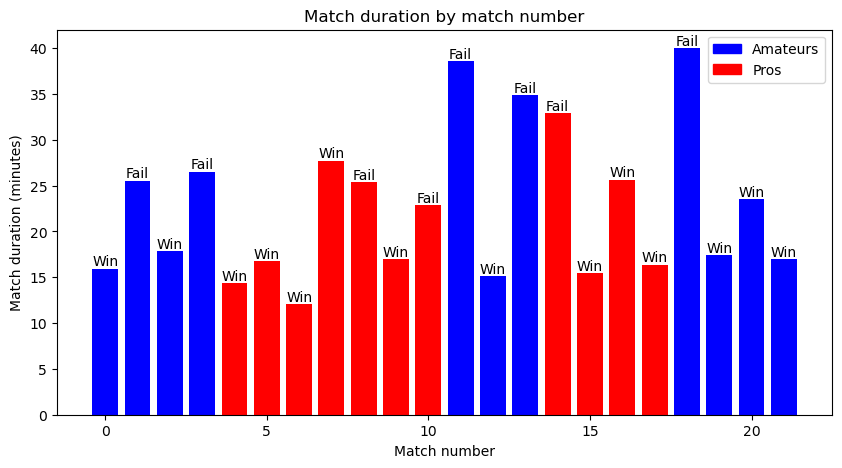

In [15]:
import matplotlib.pyplot as plt
#Visualize match by duration, team type, and win/fail
match_numbers = [int(match_key.split('_')[1]) for match_key in sorted_matches.keys()]
match_durations_seconds = [match_value['meta_info']['match_duration'] for match_value in sorted_matches.values()]
team_types = [match_value['meta_info']['team'] for match_value in sorted_matches.values()]
win_statuses = [match_value['replay']['teams']['participants']['win'] for match_value in sorted_matches.values()]

#Convert match durations from seconds to minutes
match_durations_minutes = [duration / 60 for duration in match_durations_seconds]

colors = {'amateurs': 'blue', 'pros': 'red'}

plt.figure(figsize=(10, 5))
bars = plt.bar(match_numbers, match_durations_minutes, color=[colors[team] for team in team_types])

for i in range(len(match_numbers)):
    plt.text(match_numbers[i], match_durations_minutes[i], win_statuses[i], ha='center', va='bottom')

# Adding legend for team types
legend_labels = {'amateurs': 'Amateurs', 'pros': 'Pros'}
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in legend_labels]
plt.legend(legend_handles, legend_labels.values())

plt.xlabel('Match number')
plt.ylabel('Match duration (minutes)')
plt.title('Match duration by match number')
plt.show()